In [104]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display



In [105]:
(train_images, train_labels), (valid_images, valid_labels) = tf.keras.datasets.mnist.load_data()

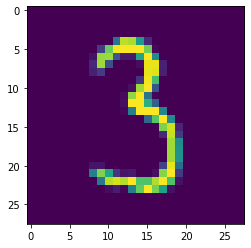

In [106]:
BATCH_SIZE = 32

def preprocess_img(data):
    data = tf.constant(data)
    data = tf.cast(data, tf.float32)
    _max = tf.reduce_max(data)
    data = data / _max
    data = tf.expand_dims(data, axis=3)
#     print("---", data.shape)
    return data
    
train_images_processed = preprocess_img(train_images)
valid_images_processed = preprocess_img(valid_images)

def duplicate(data):
    return (data, data)

train_ds = tf.data.Dataset.from_tensor_slices(train_images_processed).map(duplicate).shuffle(10000).batch(BATCH_SIZE)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_images_processed).map(duplicate).shuffle(10000).batch(BATCH_SIZE)

random_sample = next(iter(train_ds))
plt.imshow(random_sample[0][10, :, :, 0])

In [107]:
CODING_SIZE = 2

class Sampler(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2.) + mean
        

# --- encoder part
enc_inputs = tf.keras.layers.Input(shape=(28,28,1))
enc_x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides=2, activation="relu", padding="same")(enc_inputs)
enc_x = tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=2, activation="relu", padding="same")(enc_x)
enc_x = tf.keras.layers.Flatten()(enc_x)
codings_mean = tf.keras.layers.Dense(CODING_SIZE)(enc_x)
codings_log_var = tf.keras.layers.Dense(CODING_SIZE)(enc_x)
codings = Sampler()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(inputs = [enc_inputs], outputs = [codings, codings_mean, codings_log_var])

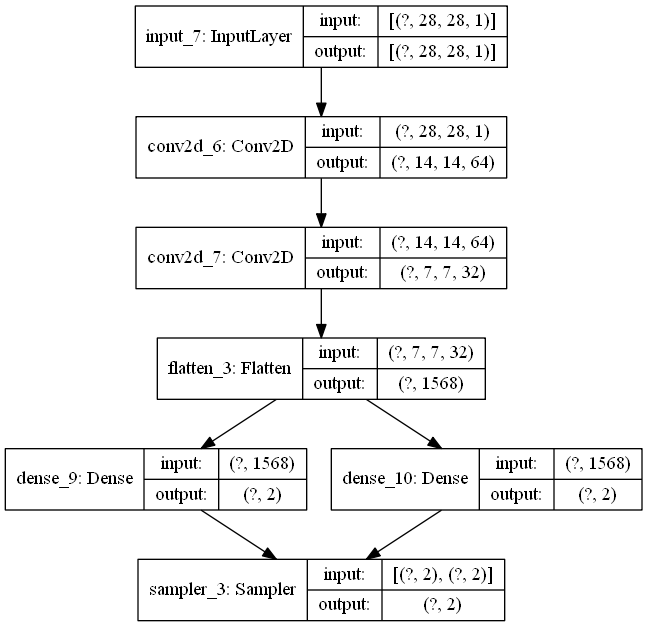

In [108]:
tf.keras.utils.plot_model(variational_encoder, show_shapes=True)

In [109]:
# --- decoder part
dec_inputs = tf.keras.layers.Input(shape = (CODING_SIZE))
dec_x = tf.keras.layers.Dense(1568)(dec_inputs)
dec_x = tf.keras.layers.Reshape(target_shape=(7,7,32))(dec_x)
dec_x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3,3), strides=2, activation="relu", padding="same")(dec_x)
dec_x = tf.keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=2, padding="same")(dec_x)

variational_decoder = tf.keras.Model(inputs = [dec_inputs], outputs = [dec_x])

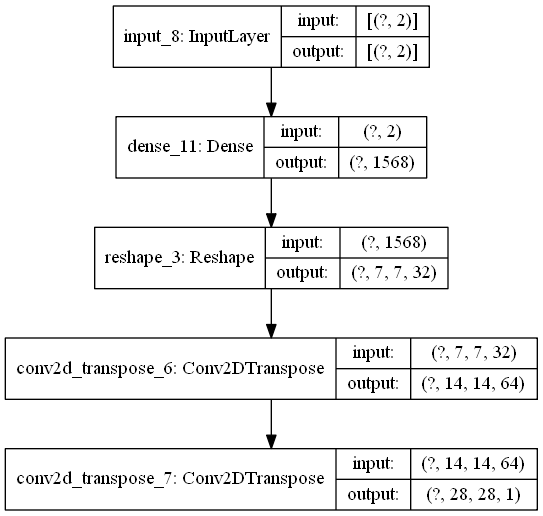

In [110]:
tf.keras.utils.plot_model(variational_decoder, show_shapes=True)

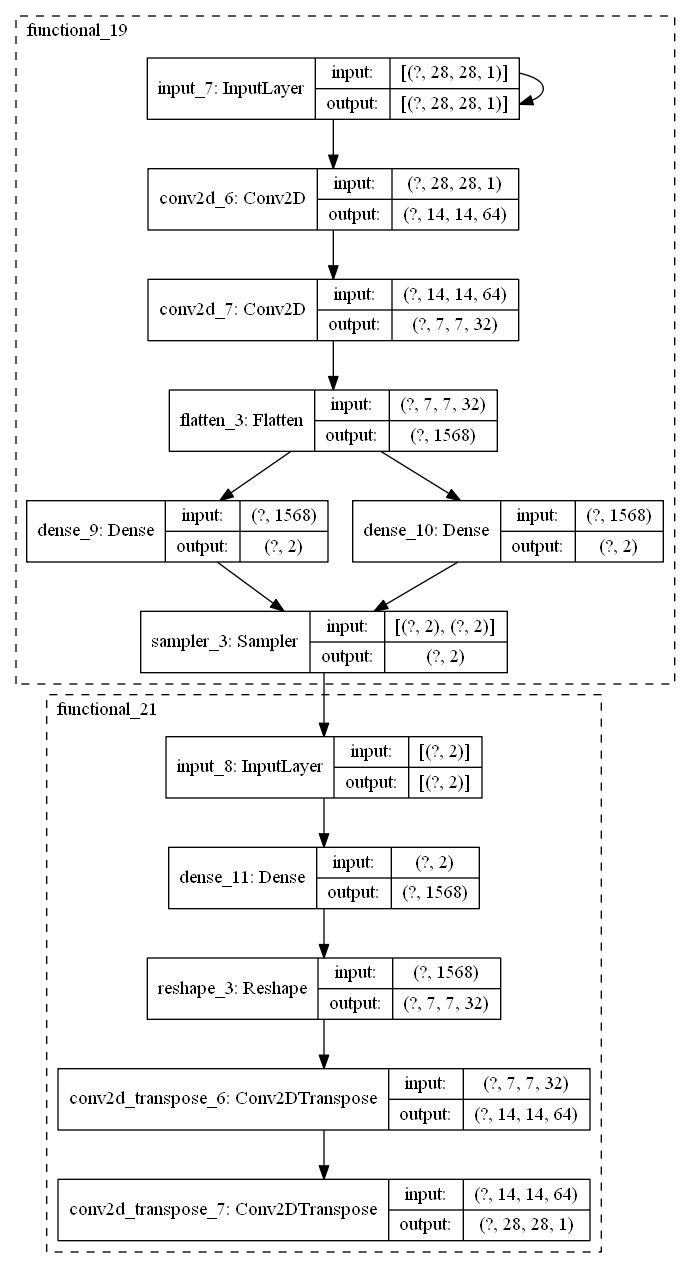

In [111]:
# vae_inputs = tf.keras.layers.Input(shape=(28,28,1))
# vae_encoding = variational_encoder(vae_inputs)

vae_encoding = variational_encoder(enc_inputs)

reconstruction = variational_decoder(vae_encoding)

vae = tf.keras.Model(inputs=[enc_inputs], outputs=[reconstruction])
tf.keras.utils.plot_model(vae, expand_nested=True, show_shapes=True)

In [112]:
def __loss(y_real, y_pred):
    loss = tf.keras.losses.MSE(y_real, y_pred)
    latent_loss = -0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
    return loss + tf.reduce_mean(latent_loss)/784.

# vae.compile(loss=__loss, optimizer="adam")

__latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1
)
vae.add_loss(tf.reduce_mean(__latent_loss)/784.)
vae.compile(loss = "mse", optimizer="adam")

In [113]:
def show_reconstructions(model, images=valid_images_processed, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index])
        plt.axis(False)
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index])
        plt.axis(False)
    plt.show()

def show_manifold():
    MANIFOLD_SIZE = 20
    DIGIT_SIZE = 28
    grid_x = np.linspace(-2, 2, MANIFOLD_SIZE)
    grid_y = np.linspace(-2, 2, MANIFOLD_SIZE)

    image = np.zeros([DIGIT_SIZE * MANIFOLD_SIZE, DIGIT_SIZE * MANIFOLD_SIZE])

    for i, iy in enumerate(grid_y):
        for j, jx in enumerate(grid_x):
            encoding = variational_decoder(tf.constant([[iy, jx]]))
            encoding = tf.squeeze(encoding)
            image[i*DIGIT_SIZE:(i + 1)*DIGIT_SIZE, j*DIGIT_SIZE:(j + 1)*DIGIT_SIZE, ] = encoding

    display.clear_output(wait=False)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis(False)
    plt.show()

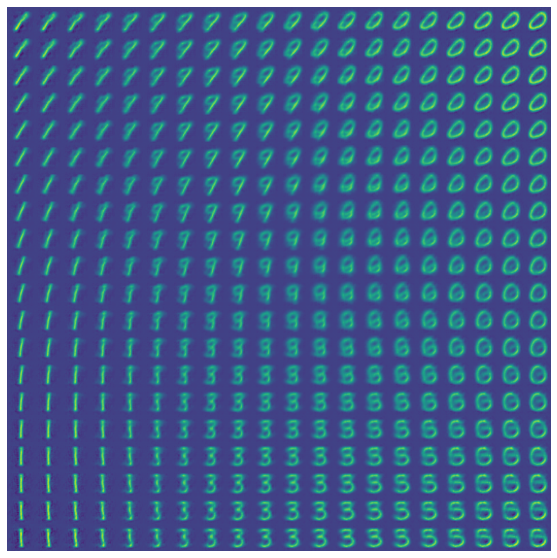

1875/1875 [==============================] - 55s 30ms/step - loss: 0.0547 - val_loss: 0.0543
Epoch 3/20
  92/1875 [>.............................] - ETA: 45s - loss: 0.0543

KeyboardInterrupt: 

In [114]:
EPOCHS=20

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, epoch, logs=None):
        show_manifold()
    def on_epoch_end(self, epoch, logs=None):
        show_manifold()
#         show_reconstructions(vae)

history = vae.fit(train_ds, epochs=EPOCHS, validation_data=(valid_ds), callbacks=[CustomCallback()])

In [ ]:
history.history

In [ ]:
white_noise = tf.random.normal([1,2])
reconstruction = variational_decoder(white_noise)
plt.subplot(1, 2, 1)
plt.imshow(reconstruction[0])
plt.subplot(1, 2, 2)
plt.imshow(reconstruction[1])

In [ ]:
MANIFOLD_SIZE = 20
DIGIT_SIZE = 28
grid_x = np.linspace(-1, 1, MANIFOLD_SIZE)
grid_y = np.linspace(-1, 1, MANIFOLD_SIZE)

image = np.zeros([DIGIT_SIZE * MANIFOLD_SIZE, DIGIT_SIZE * MANIFOLD_SIZE])

for i, iy in enumerate(grid_y):
    for j, jx in enumerate(grid_x):
        encoding = variational_decoder(tf.constant([[iy, jx]]))
        encoding = tf.squeeze(encoding)
        image[i*DIGIT_SIZE:(i + 1)*DIGIT_SIZE, j*DIGIT_SIZE:(j + 1)*DIGIT_SIZE, ] = encoding
        
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis(False)

In [ ]:
tf.random.normal([1,2])